In [1]:
# 加载模块
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

# 加载模块
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter

# 加载自定义模块
from torchLearning import *

# 加载模块中的类
from IPython.core.interactiveshell import InteractiveShell
# 设置类属性
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tensorGenCla?

Signature:
tensorGenCla(
    num_samples=500,
    num_features=2,
    num_classes=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
生成基础的分类任务数据集的函数

@param num_samples: 数据集中样本的个数
@param num_features: 数据集中每一个样本的特征变量的个数
@param num_classes: 数据集中每一个样本的分类的个数
@param deg_dispersion: 各个类别标签下的数据样本点的均值和标准差的参考数值
@param bias: 逻辑回归模型是否包含截距项

@return: 特征张量和标签
File:      ~/Desktop/prep_PhD/DL/codes/torchLearning.py
Type:      function

In [26]:
torch.manual_seed(55)

# 加载数据集
X, y = tensorGenCla(num_classes=2, bias=True)

In [27]:
# 查看特征张量的维度
X.ndim

2

In [28]:
# 查看特征张量的形状
X.shape

torch.Size([1000, 3])

In [29]:
X

tensor([[ 1.7232, -0.1929,  1.0000],
        [ 0.6789,  0.4009,  1.0000],
        [ 0.0140, -1.5242,  1.0000],
        ...,
        [ 0.2473,  2.7917,  1.0000],
        [ 4.2737,  1.2678,  1.0000],
        [ 1.8240,  0.8377,  1.0000]])

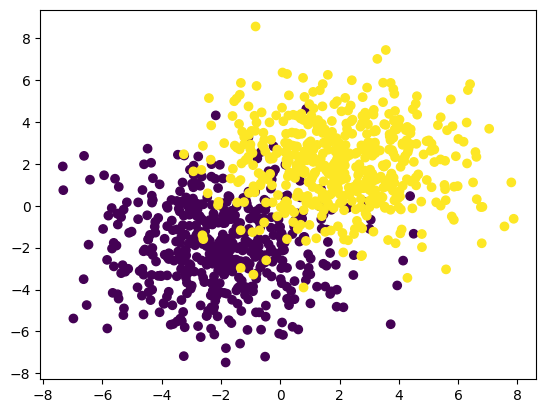

In [30]:
# 分类任务的数据集进行可视化的时候, 即可视化各个样本点. 样本点的标签是通过颜色区分的
plt.scatter(X[:, 0], X[:, 1], c=y)

In [31]:
X

tensor([[ 1.7232, -0.1929,  1.0000],
        [ 0.6789,  0.4009,  1.0000],
        [ 0.0140, -1.5242,  1.0000],
        ...,
        [ 0.2473,  2.7917,  1.0000],
        [ 4.2737,  1.2678,  1.0000],
        [ 1.8240,  0.8377,  1.0000]])

##### sigmoid函数的实现(计算流程)

In [32]:
def sigmoid(z):  # z可以是标量scaler, 也可以是向量vector
    return 1. / (1 + torch.exp(-z))

##### 逻辑回归模型的实现(计算流程)
###### 1. 数据
###### 2. 模型的参数

In [33]:
def logistic_regression(X, w):
    # 1.整合信息
    z_hat = torch.mm(X, w)
    # 2.加工信息
    sigma = sigmoid(z_hat)
    return sigma

In [34]:
def classify(sigma, p=0.5):  # sigma可以是标量scaler, 也可以是向量vector
    return (sigma >= p).float()

In [35]:
sigma = torch.tensor([0.15, 0.6, 0.9, 0.0, 1.0], dtype=torch.float32)
(sigma >= 0.5).float()

tensor([0., 1., 1., 0., 1.])

In [13]:
sigma = 0.15
float(sigma >= 0.5)

0.0

In [15]:
# 在计算机的内存中一次性存储多个随机数, 随机数服从离散型的均匀分布. 随机变量所有可能的取值
# 是0, 1, 2, 3, 4, 5, 6, 7, 8, 9
a = torch.randint(low=0, high=10, size=(5, ))
a

tensor([3, 8, 0, 6, 7])

In [16]:
a >= 5

tensor([False,  True, False,  True,  True])

In [17]:
(a >= 5).float()

tensor([0., 1., 0., 1., 1.])

##### 计算模型的分类准确率

In [20]:
def accuracy(sigma, y):
    """计算模型的分类准确率
    @param: sigma, 模型的预测输出结果, 预测当前样本属于各个类别的概率值
    @param: y, 样本的真实标签
    """
    accuracy_bool = classify(sigma=sigma).flatten() == y.flatten()
    accuracy = torch.mean(accuracy_bool.float())
    return accuracy

In [18]:
a = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float32)
a

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [19]:
a.flatten()

tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [22]:
a = torch.tensor([1, 1, 2], dtype=torch.int32)
b = torch.tensor([1, 2, 2], dtype=torch.int32)
p = (a == b)
p

tensor([ True, False,  True])

In [23]:
# 将布尔类型的张量数值化
p.float()

tensor([1., 0., 1.])

In [24]:
torch.mean(input=p.float())

tensor(0.6667)

##### 二分类任务的通用损失函数的实现(计算流程)

In [84]:
def binary_cross_entropy(sigma, y):
    """按照二分类交叉熵损失函数公式, 计算模型的预测输出标记sigma和真实标签y之间的误差
    @param sigma: 模型的预测输出标记
    @param y: 真实标签
    """
    return (-1. / len(sigma)) * torch.sum(input=y*torch.log(sigma) + (1-y)*torch.log(1-sigma))

In [85]:
y*torch.log(sigma) + (1-y)*torch.log(1-sigma)

RuntimeError: The size of tensor a (1000) must match the size of tensor b (10) at non-singleton dimension 0

In [86]:
# 前向传播
w = torch.ones(size=(X.shape[1], 1), requires_grad=True)
sigma = logistic_regression(X=X, w=w)
# 计算损失函数的取值, 即模型的预测输出标记和真实标签之间的误差
# loss = y*torch.log(sigma) + (1-y)*torch.log(1-sigma)
# loss = torch.sum(input=y*torch.log(sigma) + (1-y)*torch.log(1-sigma))
loss = 1. / len(sigma) * torch.sum(input=y*torch.log(sigma) + (1-y)*torch.log(1-sigma))
loss

tensor(-0.2279, grad_fn=<MulBackward0>)

In [87]:
loss.ndim

0

In [88]:
loss.shape

torch.Size([])

##### 优化器的实现(计算流程)
###### 优化器是借助(前向传播->反向传播)计算得到的梯度信息按照一定的方式更新模型中所有的参数

In [89]:
def stochastic_gradient_descent(params, lr):
    # 获取模型中所有参数的梯度信息
    # params.data = params - lr * params.grad
    params.data -= lr * params.grad
    # 清除已经使用过的梯度信息
    params.grad.zero_()

In [90]:
X

tensor([[ 1.7232, -0.1929,  1.0000],
        [ 0.6789,  0.4009,  1.0000],
        [ 0.0140, -1.5242,  1.0000],
        ...,
        [ 0.2473,  2.7917,  1.0000],
        [ 4.2737,  1.2678,  1.0000],
        [ 1.8240,  0.8377,  1.0000]])

In [97]:
torch.manual_seed(55)

# 加载完整的数据集(特征张量, 真实标签)

# 实例化模型
net = logistic_regression

# 选择合适的损失函数
criterion = binary_cross_entropy

# 初始化模型中的全部参数
w = torch.ones(size=(X.shape[1], 1), requires_grad=True, dtype=torch.float32)

##### 搭建训练深度神经网络模型的流程
###### 1.数据相关的设置
###### 2.优化器相关的设置

In [98]:
# =====> 数据相关的设置
# 将完整的数据集学习的遍数
n_epochs = 3
# 将一个完整的数据集按照相同的大小划分为若干个互不相交的子集
batch_size = 10

# =====> 优化器相关的设置
eta = 0.03

for i_epoch in range(n_epochs):  # 将完整的数据集学习多遍
    for i_X, i_y in split_dataset(batch_size=batch_size, X=X, y=y):  # 将一个完整的数据集划分为若干个大小相同的子数据集
        # 1.前向传播, 得到基于当前模型的参数计算出的每一个样本的模型预测输出标记
        sigma = net(X=i_X, w=w)
        # 2.计算模型预测输出标记和真实标签之间的误差, 构建完整的计算图
        loss = criterion(sigma=sigma, y=i_y)
        # 3.反向传播, 计算模型的参数的偏导函数
        loss.backward()
        # 4.使用优化器, 将当前模型的参数进行更新
        stochastic_gradient_descent(params=w, lr=eta)
        # print(loss)

    # 将完整的数据集学习一遍之后, 计算当前模型的参数计算出的完整的数据集上的模型预测输出标记和真实标签之间的分类准确度
    i_accuracy = accuracy(net(X=X, w=w), y)
    print("epoch %d, accuracy %f" % (i_epoch+1, i_accuracy))

epoch 1, accuracy 0.924000
epoch 2, accuracy 0.928000
epoch 3, accuracy 0.928000


In [99]:
w

tensor([[1.0040],
        [1.0509],
        [0.5916]], requires_grad=True)

In [100]:
torch.manual_seed(55)

# =====> 数据相关的设置
# 将完整的数据集学习的遍数
n_epochs = 20
# 将一个完整的数据集按照相同的大小划分为若干个互不相交的子集
batch_size = 10

# =====> 优化器相关的设置
eta = 0.03

# 初始化模型的参数
w = torch.ones(size=(X.shape[1], 1), requires_grad=True, dtype=torch.float32)

# 在计算机的内存中逐渐存储多个数值, 选择列表数据结构
accuracies = []

for i_epoch in range(n_epochs):  # 将完整的数据集学习多遍
    for i_X, i_y in split_dataset(batch_size=batch_size, X=X, y=y):  # 将一个完整的数据集划分为若干个大小相同的子数据集
        # 1.前向传播, 得到基于当前模型的参数计算出的每一个样本的模型预测输出标记
        sigma = net(X=i_X, w=w)
        # 2.计算模型预测输出标记和真实标签之间的误差, 构建完整的计算图
        loss = criterion(sigma=sigma, y=i_y)
        # 3.反向传播, 计算模型的参数的偏导函数
        loss.backward()
        # 4.使用优化器, 将当前模型的参数进行更新
        stochastic_gradient_descent(params=w, lr=eta)

    # 将完整的数据集学习一遍之后, 计算当前模型的参数计算出的完整的数据集上的模型预测输出标记和真实标签之间的分类准确度
    i_accuracy = accuracy(net(X=X, w=w), y)
    accuracies.append(i_accuracy)
    # print("epoch %d, accuracy %f" % (i_epoch+1, i_accuracy))

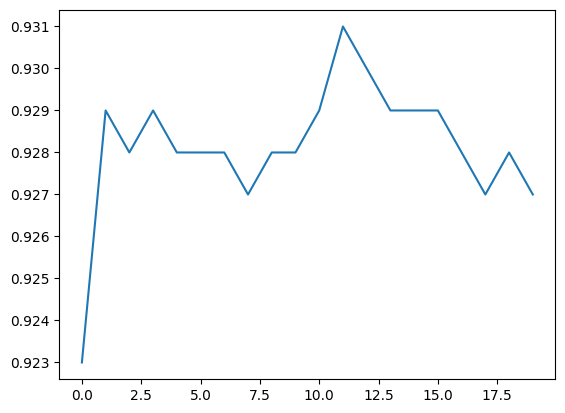

In [101]:
# 可视化准确率的变化情况, 折线图
plt.plot(list(range(n_epochs)), accuracies)

In [102]:
accuracies

[tensor(0.9230),
 tensor(0.9290),
 tensor(0.9280),
 tensor(0.9290),
 tensor(0.9280),
 tensor(0.9280),
 tensor(0.9280),
 tensor(0.9270),
 tensor(0.9280),
 tensor(0.9280),
 tensor(0.9290),
 tensor(0.9310),
 tensor(0.9300),
 tensor(0.9290),
 tensor(0.9290),
 tensor(0.9290),
 tensor(0.9280),
 tensor(0.9270),
 tensor(0.9280),
 tensor(0.9270)]

In [103]:
tensorGenCla?

Signature:
tensorGenCla(
    num_samples=500,
    num_features=2,
    num_classes=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
生成基础的分类任务数据集的函数

@param num_samples: 数据集中样本的个数
@param num_features: 数据集中每一个样本的特征变量的个数
@param num_classes: 数据集中每一个样本的分类的个数
@param deg_dispersion: 各个类别标签下的数据样本点的均值和标准差的参考数值
@param bias: 逻辑回归模型是否包含截距项

@return: 特征张量和标签
File:      ~/Desktop/prep_PhD/DL/codes/torchLearning.py
Type:      function

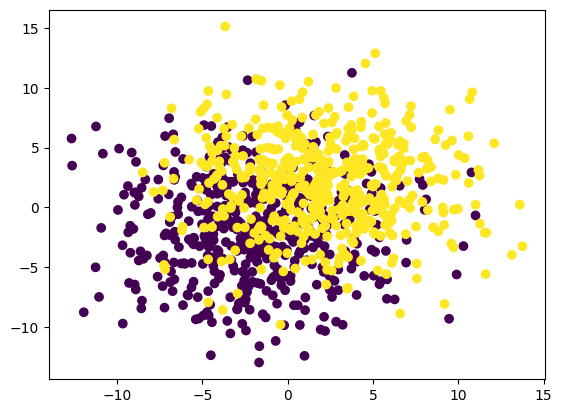

In [104]:
torch.manual_seed(55)

X, y = tensorGenCla(num_classes=2, deg_dispersion=[4, 4], bias=True)

# 可视化
plt.scatter(X[:, 0], X[:, 1], c=y)

In [124]:
torch.manual_seed(55)

# =====> 数据相关的设置
# 将完整的数据集学习的遍数
n_epochs = 20
# 将一个完整的数据集按照相同的大小划分为若干个互不相交的子集
batch_size = 10

# =====> 优化器相关的设置
eta = 0.05

# 初始化模型的参数
w = torch.zeros(size=(X.shape[1], 1), requires_grad=True, dtype=torch.float32)

# 在计算机的内存中逐渐存储多个数值, 选择列表数据结构
accuracies = []
# 在计算机的内存中逐渐存储多个数值, 选择列表数据结构
losses = []

for i_epoch in range(n_epochs):  # 将完整的数据集学习多遍
    for i_X, i_y in split_dataset(batch_size=batch_size, X=X, y=y):  # 将一个完整的数据集划分为若干个大小相同的子数据集
        # 1.前向传播, 得到基于当前模型的参数计算出的每一个样本的模型预测输出标记
        sigma = net(X=i_X, w=w)
        # 2.计算模型预测输出标记和真实标签之间的误差, 构建完整的计算图
        loss = criterion(sigma=sigma, y=i_y)
        # 3.反向传播, 计算模型的参数的偏导函数
        loss.backward()
        # 4.使用优化器, 将当前模型的参数进行更新
        stochastic_gradient_descent(params=w, lr=eta)

        losses.append(loss)
        

    # 将完整的数据集学习一遍之后, 计算当前模型的参数计算出的完整的数据集上的模型预测输出标记和真实标签之间的分类准确度
    i_accuracy = accuracy(net(X=X, w=w), y)
    accuracies.append(i_accuracy)
    # print("epoch %d, accuracy %f" % (i_epoch+1, i_accuracy))

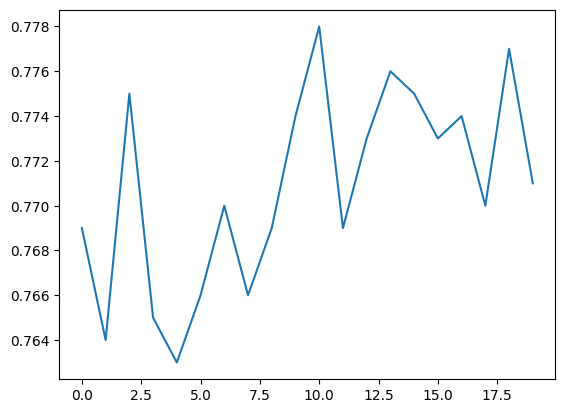

In [125]:
plt.plot(list(range(n_epochs)), accuracies)

In [113]:
batched_dataset = split_dataset(batch_size=batch_size, X=X, y=y)
# 查看数据集中包含多少个互不相交的子集
len(batched_dataset)

100

In [126]:
# plt.plot(list(range(n_epochs * len(batched_dataset))), losses)
losses

[tensor(0.6931, grad_fn=<MulBackward0>),
 tensor(0.6225, grad_fn=<MulBackward0>),
 tensor(0.4974, grad_fn=<MulBackward0>),
 tensor(0.6739, grad_fn=<MulBackward0>),
 tensor(0.4333, grad_fn=<MulBackward0>),
 tensor(0.6034, grad_fn=<MulBackward0>),
 tensor(0.6096, grad_fn=<MulBackward0>),
 tensor(0.4116, grad_fn=<MulBackward0>),
 tensor(0.4285, grad_fn=<MulBackward0>),
 tensor(0.4247, grad_fn=<MulBackward0>),
 tensor(0.3138, grad_fn=<MulBackward0>),
 tensor(0.2735, grad_fn=<MulBackward0>),
 tensor(0.5612, grad_fn=<MulBackward0>),
 tensor(0.2948, grad_fn=<MulBackward0>),
 tensor(0.3495, grad_fn=<MulBackward0>),
 tensor(0.5044, grad_fn=<MulBackward0>),
 tensor(0.2658, grad_fn=<MulBackward0>),
 tensor(0.5978, grad_fn=<MulBackward0>),
 tensor(0.5112, grad_fn=<MulBackward0>),
 tensor(0.3472, grad_fn=<MulBackward0>),
 tensor(0.6141, grad_fn=<MulBackward0>),
 tensor(0.6640, grad_fn=<MulBackward0>),
 tensor(0.3823, grad_fn=<MulBackward0>),
 tensor(0.4549, grad_fn=<MulBackward0>),
 tensor(0.6642, 

##### 加载原始数据, 对原始数据进行预处理

In [150]:
torch.manual_seed(55)

X, y = tensorGenCla(num_classes=2)
# 在pytorch框架中, 参与计算的张量定义为浮点数类型
y = y.float()

In [133]:
X

tensor([[ 1.7232, -0.1929],
        [ 0.6789,  0.4009],
        [ 0.0140, -1.5242],
        ...,
        [ 0.2473,  2.7917],
        [ 4.2737,  1.2678],
        [ 1.8240,  0.8377]])

In [134]:
y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

##### 搭建深度神经网络模型
###### 使用面向对象(定义类/创建对象)的方式 继承nn.Module类

In [151]:
class GeoffNet(nn.Module):
    
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, out_features=1):
        super(GeoffNet, self).__init__()

        # 输出层
        self.output_linear = nn.Linear(in_features=in_features, out_features=out_features)

    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        # 输出层 -> 输出层
        z_hat = self.output_linear(X)
        return z_hat

##### 搭建训练深度神经网络模型流程

In [142]:
# 数据
# 1.将特征张量和标签按照样本索引对齐的方式进行打包, 得到完整的数据集
dataset = TensorDataset(X, y)
# 2.将一个完整的数据集按照固定的大小划分为若干个互不相交的子数据集
batch_size = 10
batched_dataset = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)
# 3.将一个完整的数据集学习的遍数
n_epochs = 3

# 实例化模型
input_ = X.shape[1]
output_ = len(y.unique())  # 出错!!!
# net = GeoffNet(in_features=input_, out_features=output_)
net = GeoffNet(in_features=input_, out_features=1)

# 选择损失函数
criterion = nn.BCEWithLogitsLoss()

# 选择优化器
eta = 0.03
optimizer = optim.SGD(params=net.parameters(), lr=eta)

# 训练流程
def fit(batched_dataset, n_epochs, model, criterion, optimizer):
    for i_epoch in range(n_epochs):  # 将一个完整的数据集学习多遍
        for (i_X, i_y) in batched_dataset:  # 将一个完整的数据集划分为若干个互不相交的子数据集逐个进行训练
            # 1.前向传播
            z_hat = model.forward(i_X)
            # 2.计算损失, 模型的预测输出标记和真实标签之间的误差. 构建完整的计算图
            loss = criterion(z_hat, i_y)
            # 3.反向传播, 计算模型中所有参数作为自变量构成的损失函数相对于各个参数的偏导函数
            loss.backward()
            # 4.使用优化器借助梯度信息, 按照一定的原则更新模型中全部的参数
            optimizer.step()
            optimizer.zero_grad()
            # print(i_X.shape)
            # print(z_hat.shape)
            # print(i_y.shape)
            # break

In [143]:
# 拟合
torch.manual_seed(55)

fit(batched_dataset=batched_dataset, n_epochs=n_epochs,
   model=net,
   criterion=criterion,
   optimizer=optimizer)

In [144]:
net

GeoffNet(
  (output_linear): Linear(in_features=2, out_features=1, bias=True)
)

In [145]:
# 查看模型中全部的参数
net.parameters()

<generator object Module.parameters at 0x12b99c3c0>

In [146]:
list(net.parameters())

[Parameter containing:
 tensor([[0.8334, 0.9032]], requires_grad=True),
 Parameter containing:
 tensor([-0.0059], requires_grad=True)]

In [147]:
loss = criterion(net.forward(X), y)
loss

tensor(0.1978, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [148]:
def acc_zhat(z_hat, y):
    sigma = sigmoid(z_hat)
    return accuracy(sigma, y)

In [149]:
acc_zhat(net.forward(X), y)

tensor(0.9270)

In [155]:
# 数据
# 1.将特征张量和标签按照样本索引对齐的方式进行打包, 得到完整的数据集
dataset = TensorDataset(X, y)
# 2.将一个完整的数据集按照固定的大小划分为若干个互不相交的子数据集
batch_size = 10
batched_dataset = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)
# 3.将一个完整的数据集学习的遍数
n_epochs = 20

# 实例化模型
input_ = X.shape[1]
output_ = len(y.unique())  # 出错!!!
# net = GeoffNet(in_features=input_, out_features=output_)
net = GeoffNet(in_features=input_, out_features=1)

# 选择损失函数
criterion = nn.BCEWithLogitsLoss()

# 选择优化器
eta = 0.03
optimizer = optim.SGD(params=net.parameters(), lr=eta)

# 在计算机的内存中逐个存储多个数, 选择列表作为数据结构
accuracies = []

# 训练流程
def fit(batched_dataset, n_epochs, model, criterion, optimizer):
    for i_epoch in range(n_epochs):  # 将一个完整的数据集学习多遍
        for (i_X, i_y) in batched_dataset:  # 将一个完整的数据集划分为若干个互不相交的子数据集逐个进行训练
            # 1.前向传播
            z_hat = model.forward(i_X)
            # 2.计算损失, 模型的预测输出标记和真实标签之间的误差. 构建完整的计算图
            loss = criterion(z_hat, i_y)
            # 3.反向传播, 计算模型中所有参数作为自变量构成的损失函数相对于各个参数的偏导函数
            loss.backward()
            # 4.使用优化器借助梯度信息, 按照一定的原则更新模型中全部的参数
            optimizer.step()
            optimizer.zero_grad()

        # 在完整学习完一遍数据集之后, 计算基于当前模型的参数对于完整数据集的模型预测输出标记与真实标签之间的 分类准确度
        i_accuracy = acc_zhat(model.forward(X), y)
        accuracies.append(i_accuracy)

In [156]:
# 拟合
torch.manual_seed(55)

fit(batched_dataset=batched_dataset, n_epochs=n_epochs,
   model=net,
   criterion=criterion,
   optimizer=optimizer)

In [157]:
len(accuracies)

20

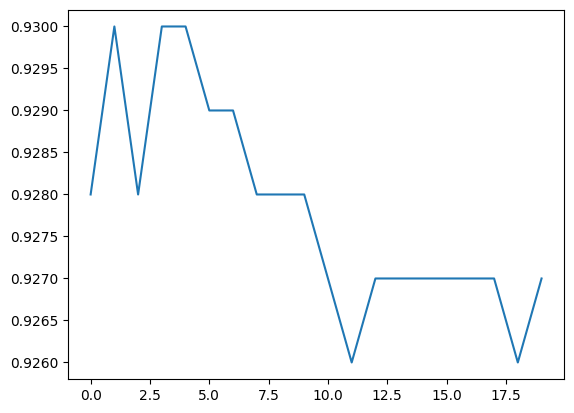

In [158]:
plt.plot(list(range(n_epochs)), accuracies)

In [159]:
accuracies

[tensor(0.9280),
 tensor(0.9300),
 tensor(0.9280),
 tensor(0.9300),
 tensor(0.9300),
 tensor(0.9290),
 tensor(0.9290),
 tensor(0.9280),
 tensor(0.9280),
 tensor(0.9280),
 tensor(0.9270),
 tensor(0.9260),
 tensor(0.9270),
 tensor(0.9270),
 tensor(0.9270),
 tensor(0.9270),
 tensor(0.9270),
 tensor(0.9270),
 tensor(0.9260),
 tensor(0.9270)]

In [160]:
class GeoffNet(nn.Module):
    
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, out_features=1):
        super(GeoffNet, self).__init__()

        # 输出层
        self.output_linear = nn.Linear(in_features=in_features, out_features=out_features)

    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        # 输出层 -> 输出层
        z_hat = self.output_linear(X)
        return z_hat

In [161]:
# 第一次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.5158, 0.1257]], requires_grad=True),
 Parameter containing:
 tensor([-0.6787], requires_grad=True)]

In [162]:
# 第二次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[-0.4157,  0.6765]], requires_grad=True),
 Parameter containing:
 tensor([0.3080], requires_grad=True)]

In [163]:
# 设置随机数发生器的随机数种子
torch.manual_seed(55)

In [164]:
# 再次设置随机数发生器的随机数种子
torch.manual_seed(55)

In [165]:
# 第一次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.4748, 0.6191]], requires_grad=True),
 Parameter containing:
 tensor([0.3449], requires_grad=True)]

In [166]:
# 第二次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.0954, 0.5207]], requires_grad=True),
 Parameter containing:
 tensor([-0.0333], requires_grad=True)]

In [167]:
# 第一次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[-0.5858,  0.3876]], requires_grad=True),
 Parameter containing:
 tensor([0.6614], requires_grad=True)]

In [168]:
# 第二次实例化模型
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[-0.4421, -0.5666]], requires_grad=True),
 Parameter containing:
 tensor([-0.6207], requires_grad=True)]

In [169]:
lst = list(range(5))
lst

random.shuffle(lst)
lst

[0, 1, 2, 3, 4]

[3, 0, 1, 2, 4]

In [170]:
torch.manual_seed(55)
lst = list(range(5))
lst

random.shuffle(lst)
lst

[0, 1, 2, 3, 4]

[3, 1, 2, 0, 4]

In [171]:
torch.manual_seed(55)
lst = list(range(5))
lst

random.shuffle(lst)
lst

[0, 1, 2, 3, 4]

[3, 1, 0, 4, 2]

In [172]:
random.seed(55)
lst = list(range(5))
lst

random.shuffle(lst)
lst

[0, 1, 2, 3, 4]

[2, 3, 4, 1, 0]

In [173]:
random.seed(55)
lst = list(range(5))
lst

random.shuffle(lst)
lst

[0, 1, 2, 3, 4]

[2, 3, 4, 1, 0]

In [176]:
# 模型的参数的随机初始化是通过torch.manual_seed()控制的
torch.manual_seed(55)
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.4748, 0.6191]], requires_grad=True),
 Parameter containing:
 tensor([0.3449], requires_grad=True)]

In [177]:
# 模型的参数的随机初始化是通过torch.manual_seed()控制的
torch.manual_seed(55)
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.4748, 0.6191]], requires_grad=True),
 Parameter containing:
 tensor([0.3449], requires_grad=True)]

In [180]:
# 模型的参数的随机初始化是通过torch.manual_seed() 或者 torch.random.manual_seed()控制的
torch.random.manual_seed(55)
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.4748, 0.6191]], requires_grad=True),
 Parameter containing:
 tensor([0.3449], requires_grad=True)]

In [181]:
# 模型的参数的随机初始化是通过torch.manual_seed()控制的
torch.random.manual_seed(55)
list(GeoffNet().parameters())

[Parameter containing:
 tensor([[0.4748, 0.6191]], requires_grad=True),
 Parameter containing:
 tensor([0.3449], requires_grad=True)]